## **Table of Contents**
* ### [0. Imports and Defaults](#imports) ###
* ### [1. Processing the Data](#process-data) ###
  * #### [1.1. Load Apogee Labels](#load-ap-data) ####
  * #### [1.3. Visualise Key Labels](#vis-data) ####
  * #### [1.4. Plot Representative Spectra](#rep-spec) ####
  * #### [1.4. Load JWST Data](#load-jwst-data) ####
  * #### [1.5. Selected Plots](#sel-plots) ####
* ### [2. Build Neural Network Predictor](#build-model) ###
  * #### [2.1 Partition the Data](#part-data) ####


## **0. Imports and Defaults** <a class="anchor" id="imports"></a>

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from corner import corner
from pathlib import Path
from astropy.io import fits
import matplotlib.gridspec as gridspec

# ml
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# pytorch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import lr_scheduler
from torchsummary import summary

import time

In [ ]:
plt.rcParams.update({
    "text.usetex": True,  # Use LaTeX for all text
    "font.family": "serif",  # Use serif fonts (like Computer Modern)
})

In [ ]:
cs = ["#335c67","#fff3b0","#e09f3e","#9e2a2b","#540b0e"]
os.makedirs('figures', exist_ok= True)

This notebook documents my progress in the CTA200 Mini Project. In this analysis, I conduct preliminary analysis of the APOGEE stellar spectra.

# **1. Processing the Data** <a class="anchor" id="process-data"></a>

## **1.1 Load Apogee Labels** <a class = "anchor" id ="load-ap-data">

In [ ]:
#load in the apogee spectra
APOGEE_dir = '/geir_data/scr/sandford/apogee_dr17.h5'
allstars = pd.read_hdf(APOGEE_dir, 'allstar')

In [ ]:
print('There are {} stars in the APOGEE DR17 sample'.format(len(allstars)))
print('The stellar labels examined are {}'.format(list(allstars.columns)))

There are 19800 stars in the APOGEE DR17 sample
The stellar labels examined are ['FILE', 'APOGEE_ID', 'TELESCOPE', 'FIELD', 'RA', 'DEC', 'SNR', 'VHELIO_AVG', 'VERR', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'M_H', 'M_H_ERR', 'ALPHA_M', 'ALPHA_M_ERR', 'VMICRO', 'VMACRO', 'C_FE', 'C_FE_ERR', 'N_FE', 'N_FE_ERR', 'O_FE', 'O_FE_ERR', 'NA_FE', 'NA_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR', 'TI_FE', 'TI_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR', 'MN_FE', 'MN_FE_ERR', 'FE_H', 'FE_H_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR', 'CE_FE', 'CE_FE_ERR']


We see that this dataset includes a multitude of stellar properties, including position, effective temperature, surface gravity, and different elemental abundances. Included are abundances of C, Fe, N, O, Na, Mg, Al, Si, S, K, Ca, Ti, V, Cr, Mn, Co, Ni, and Ce.

## **1.2 Visualize Key Labels** <a class = "anchor" id = "vis-data">

Create a couple plots to visualize the data

In [ ]:
#A 2-dimensional histogram log g (surface gravity) vs. Teff (effective temperature)
logg = allstars['LOGG']
Teff = allstars['TEFF']

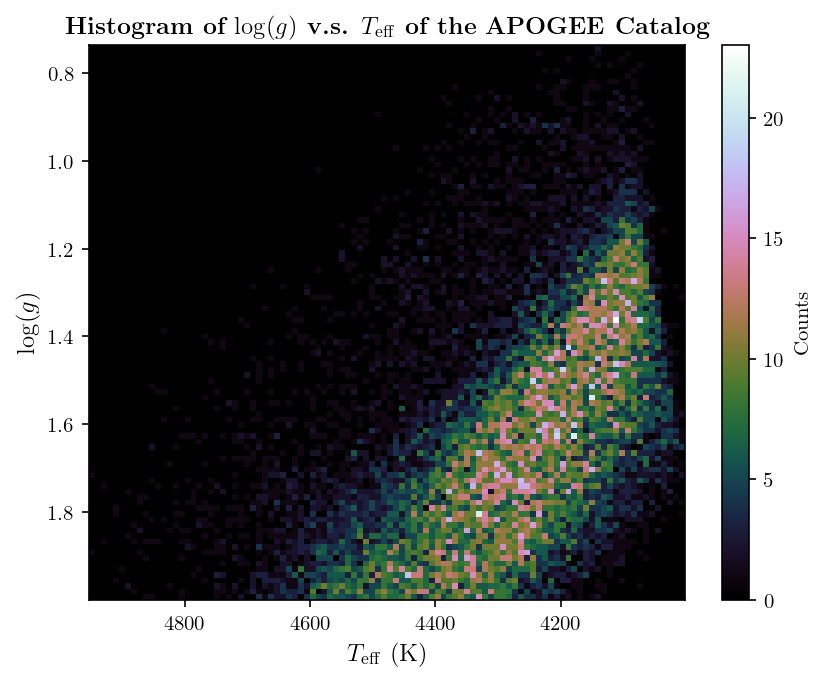

In [ ]:
fig, ax = plt.subplots(dpi = 150)
plt.hist2d(Teff, logg, bins = 100, cmap='cubehelix')
plt.colorbar(label='Counts')
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_ylabel('$\log(g)$', fontsize = 12)
ax.set_xlabel(r'$T_{ \mathrm{eff} }$ (K)', fontsize = 12)
ax.set_title(r'\textbf{Histogram of $\log(g)$ v.s. $T_{\mathrm{eff}}$  of the APOGEE Catalog}')
plt.savefig('figures/logg_Teff_hist.pdf')
plt.show()

In [ ]:
# A 1-dimensional histogram of the distribution of stars as a function of [Fe/H]
FeH = allstars['FE_H']

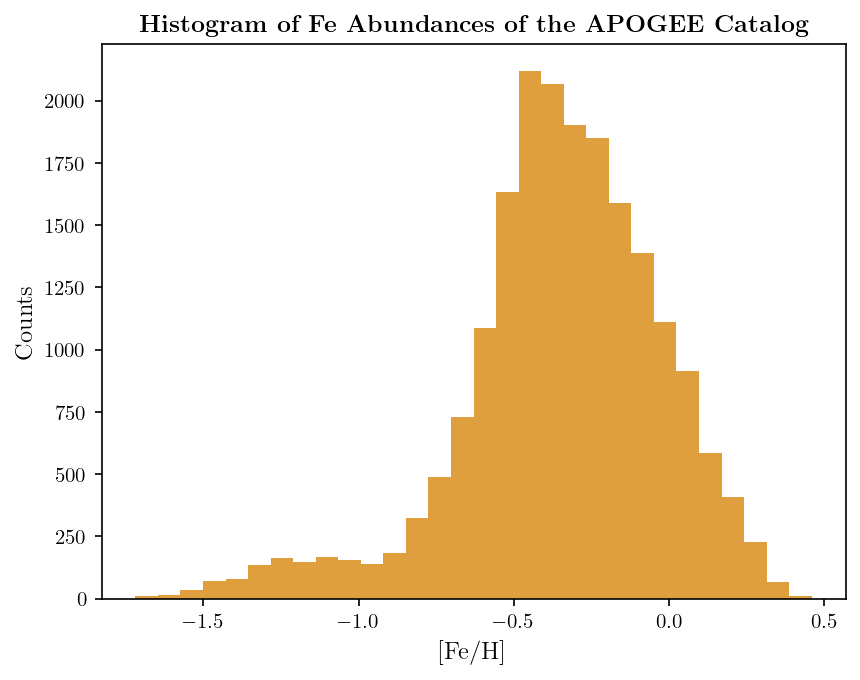

In [ ]:
plt.figure(dpi = 150)
plt.hist(FeH, bins=30, color = cs[2])
plt.xlabel('[Fe/H]', fontsize = 12)
plt.ylabel(r'Counts', fontsize = 12)
plt.title(r'\textbf{Histogram of Fe Abundances of the APOGEE Catalog}')
plt.savefig('figures/Fe_hist.pdf')
plt.show()

In [ ]:
# A 2-dimensional histogram of [Mg/Fe] vs. [Fe/H]
MgFe = allstars['MG_FE']

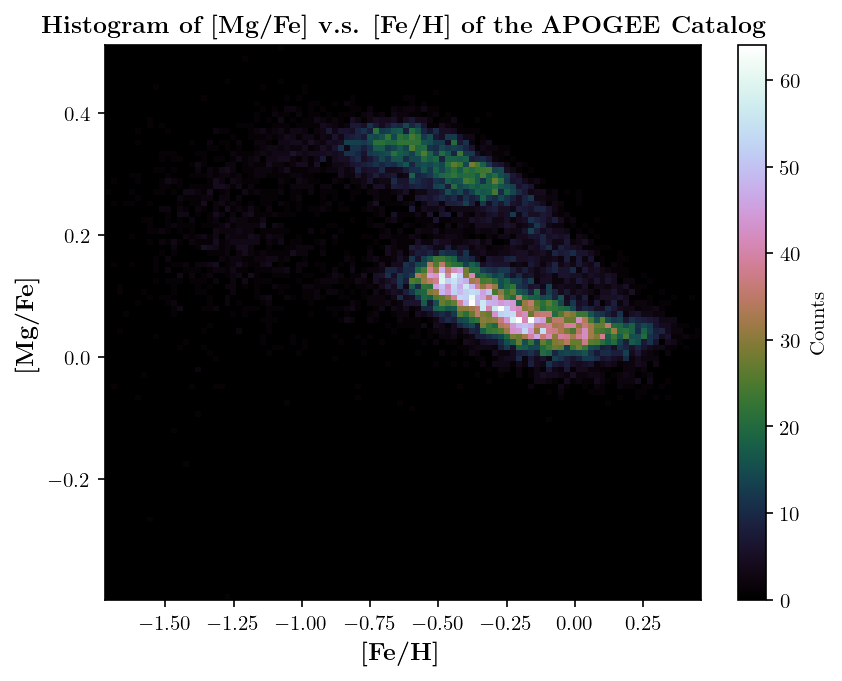

In [ ]:
fig, ax = plt.subplots(dpi = 150)
plt.hist2d(FeH, MgFe, bins = 100, cmap='cubehelix')
plt.colorbar(label='Counts')
ax.set_ylabel(r'\textbf{[Mg/Fe]}', fontsize = 12)
ax.set_xlabel(r'\textbf{[Fe/H]}', fontsize = 12)
ax.set_title(r'\textbf{Histogram of [Mg/Fe] v.s. [Fe/H] of the APOGEE Catalog}')

plt.savefig('figures/MgFe_FeH_hist.pdf')
plt.show()

In [ ]:
#select relevant columns
stellarparams = ['TEFF', 'LOGG', 'FE_H', 'C_FE', 'N_FE', 'MG_FE', 'SI_FE', 'CA_FE', 'TI_FE']
allstars_params = allstars[stellarparams]

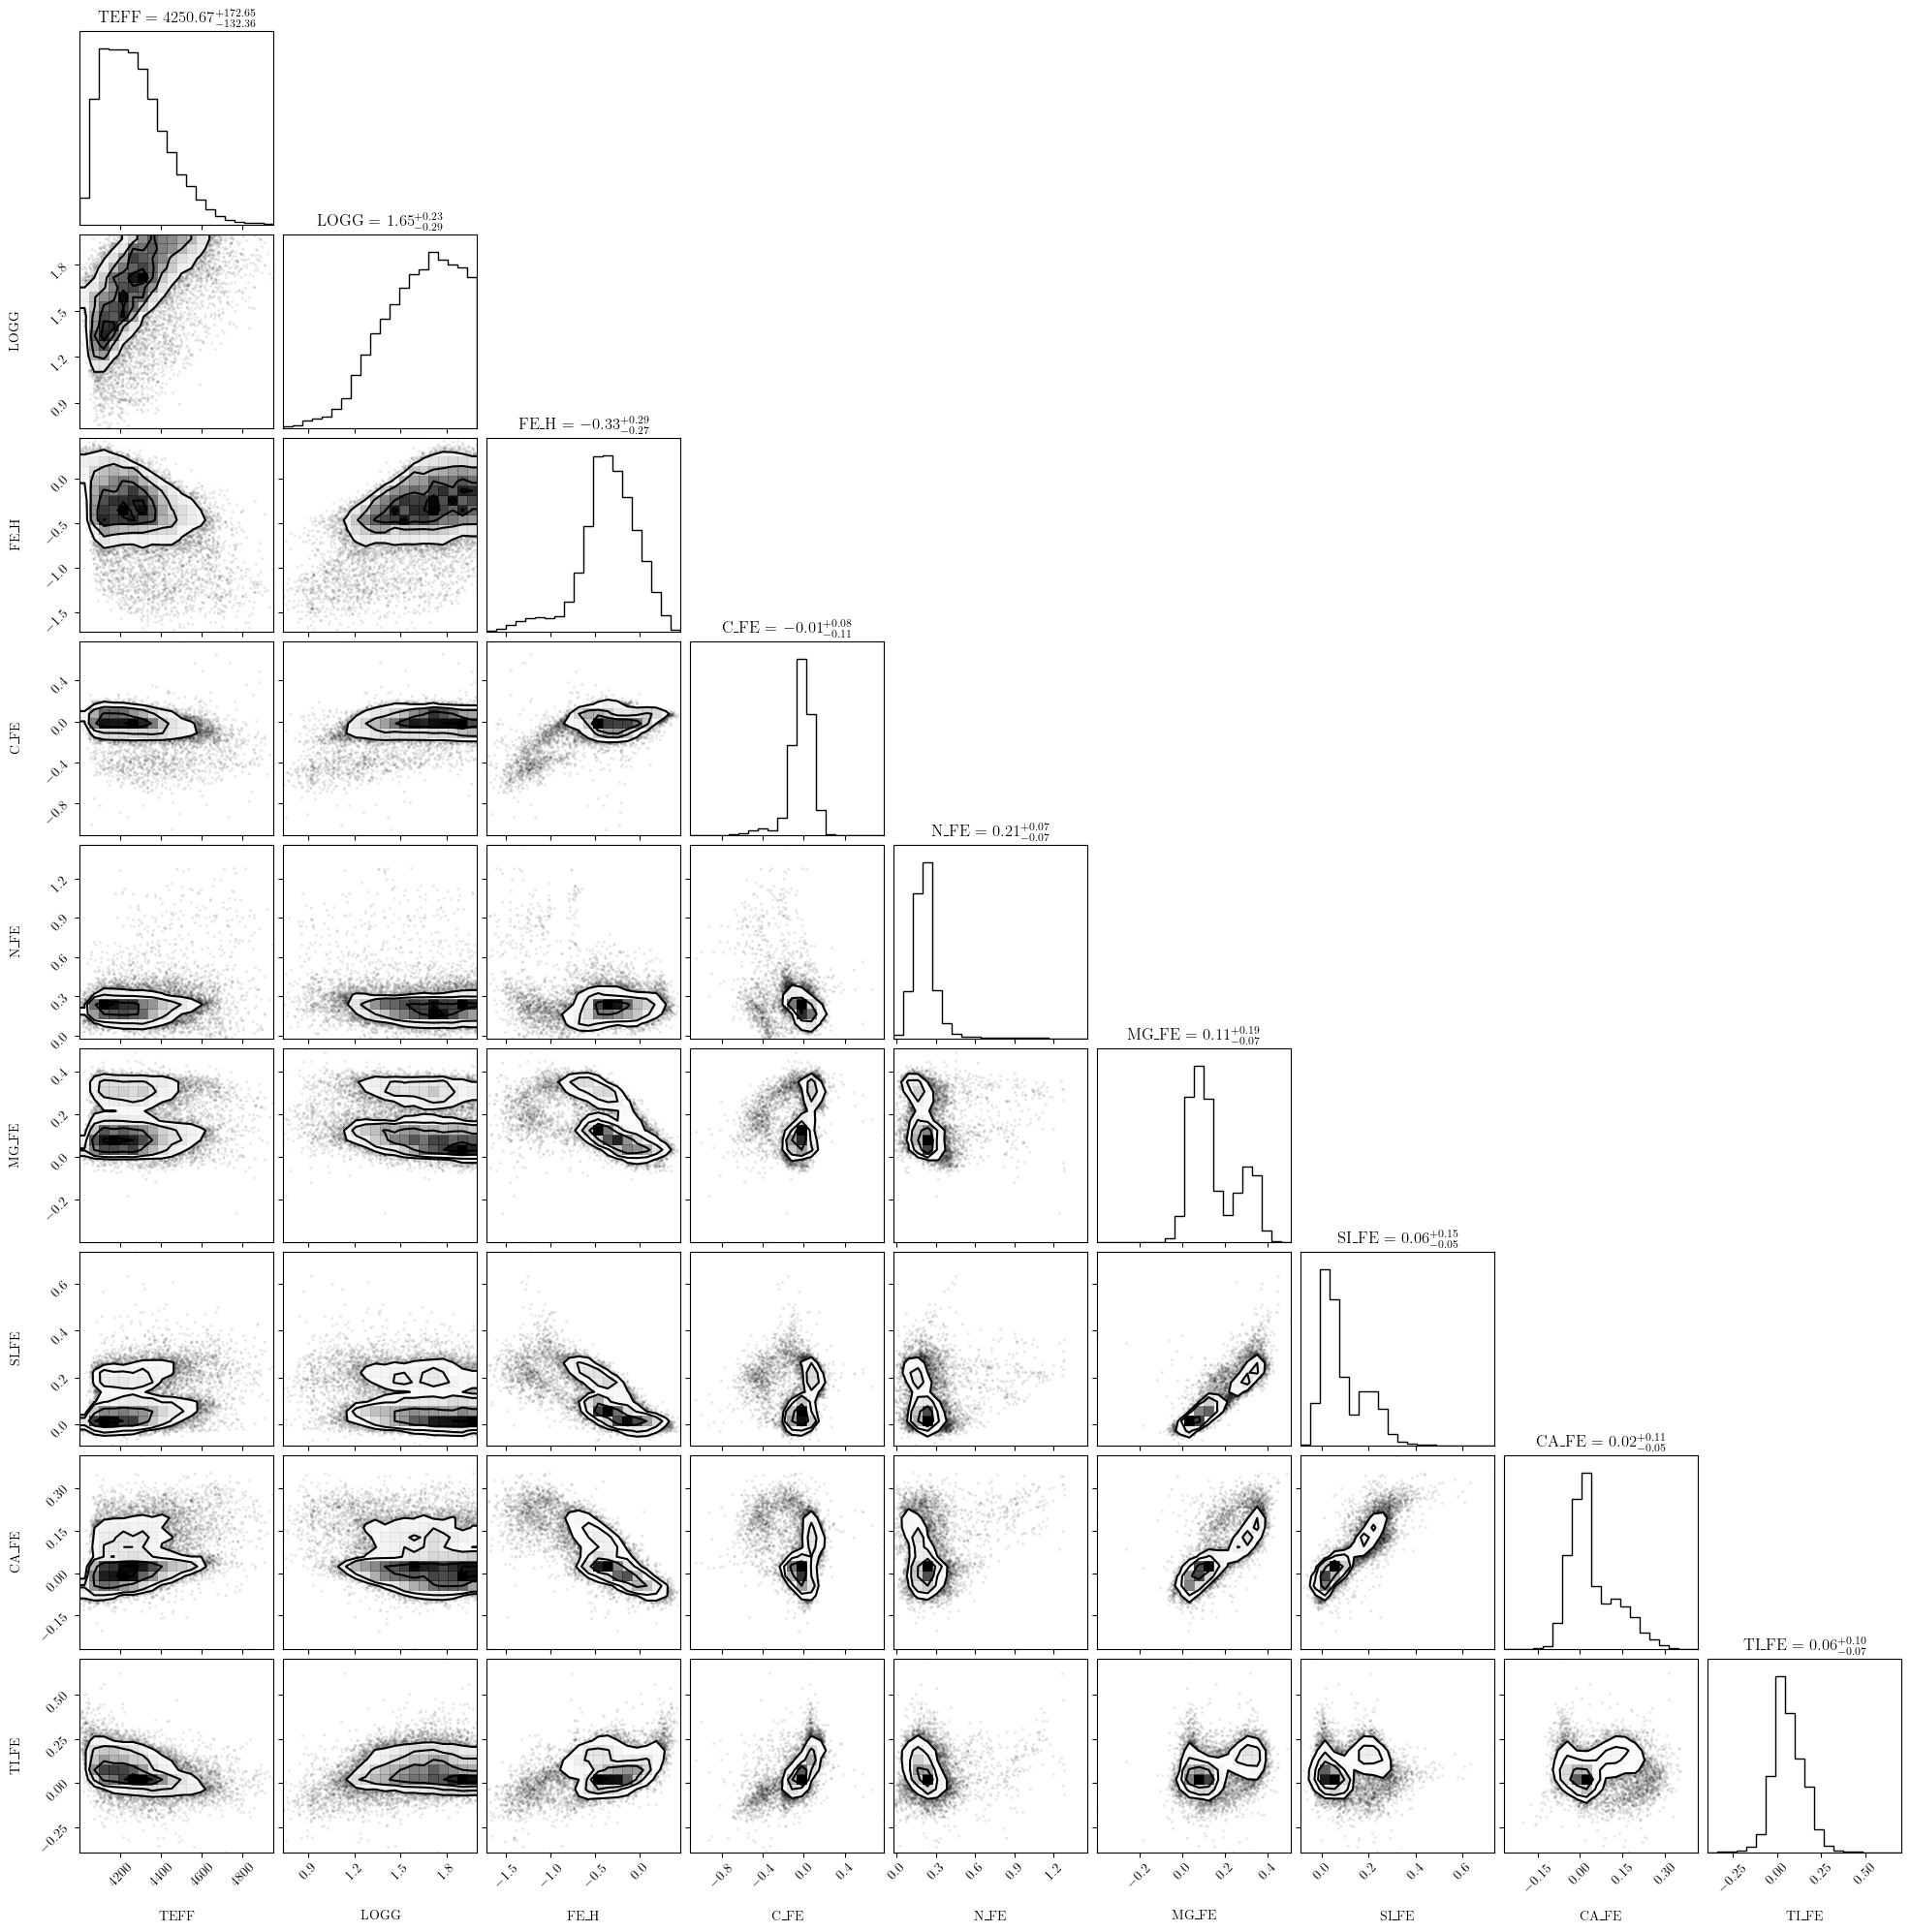

In [ ]:
figure = corner(allstars_params, labels = stellarparams, show_titles = True)

## **1.3 Plot Representative Spectra** <a class = "anchor" id = "rep-spec">

In [ ]:
selected = allstars.sample(10).reset_index()

In [ ]:
#Path to data
data_dir = Path('/yngve_data/')
apogee_dr17_dir = data_dir / 'sdss/apogee/dr17/apogee/spectro/aspcap/dr17/synspec'

In [ ]:
#apogee wavelength grid
_LOG10LAMBDA0 = 4.179
_DLOG10LAMBDA = 6. * 10.**-6.
_NLAMBDA = 8575
apogee_wave = 10.**np.arange(
    _LOG10LAMBDA0,
    _LOG10LAMBDA0 +_NLAMBDA * _DLOG10LAMBDA,
    _DLOG10LAMBDA
)

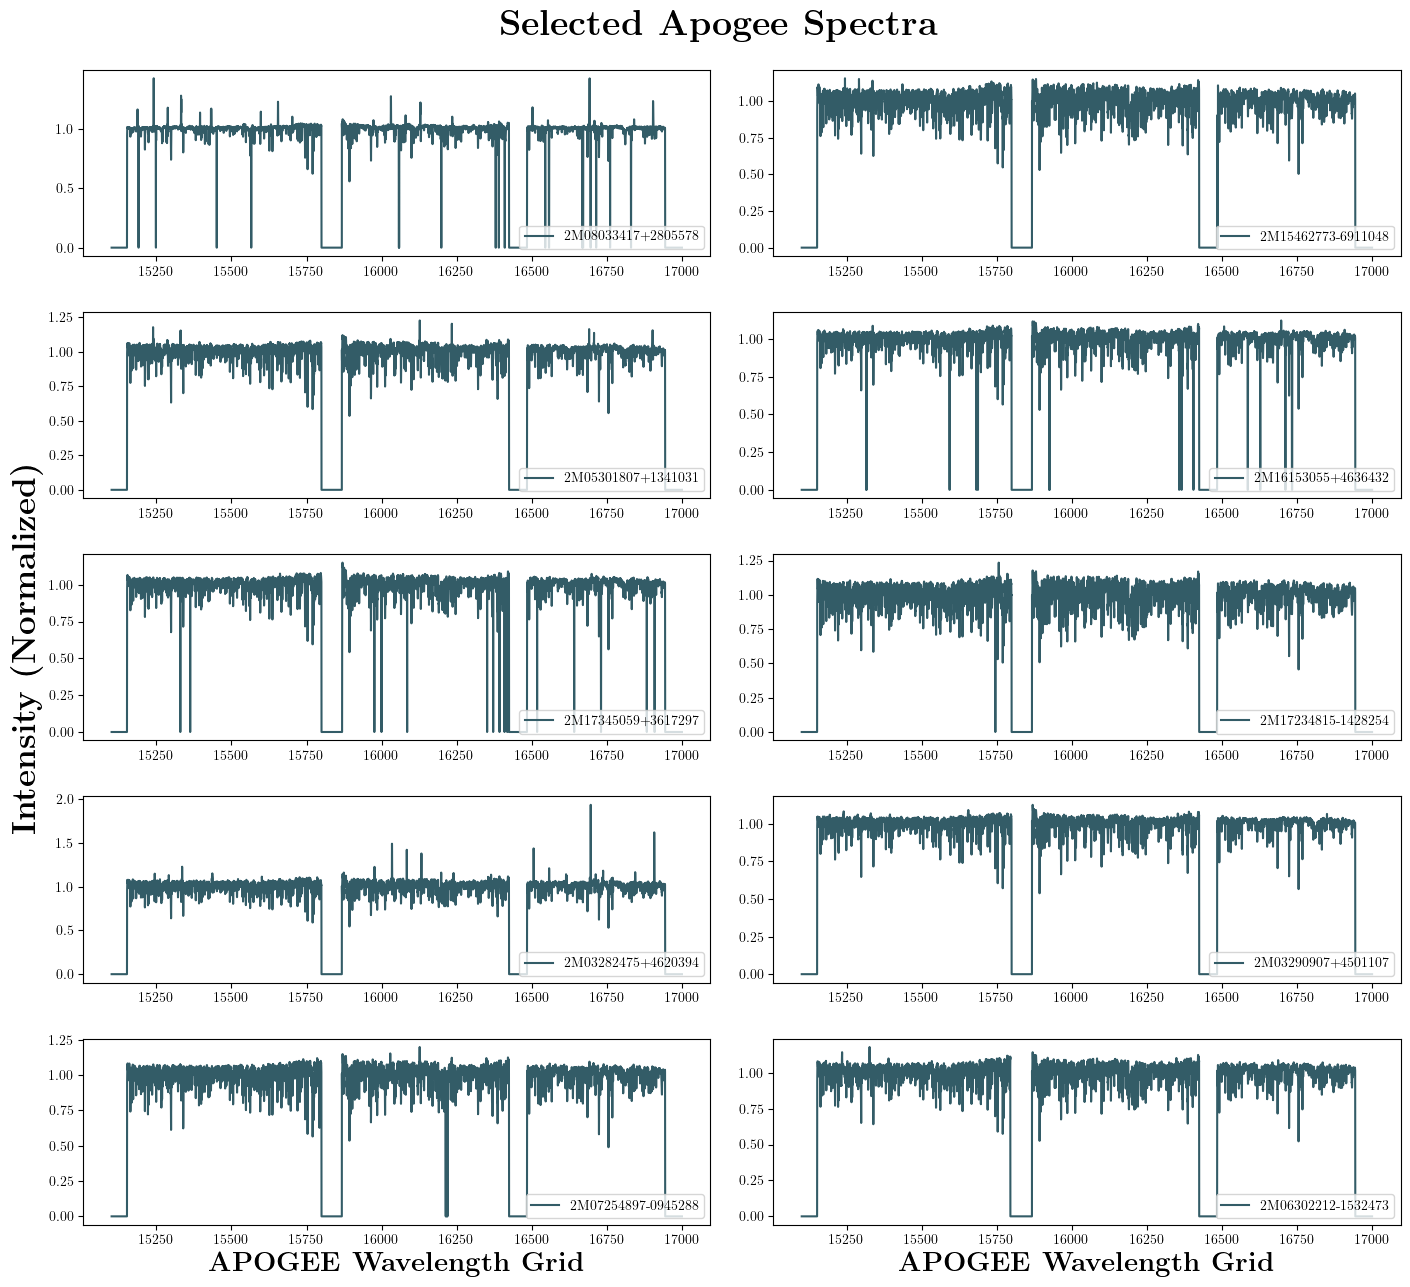

In [ ]:
# Plot a few APOGEE spectra
# Create a figure
fig = plt.figure(figsize=(17, 15))  # Adjust the figure size as needed

# Create a GridSpec object with 5 rows and 2 columns
gs = gridspec.GridSpec(5, 2, figure=fig)
gs.update(wspace=0.1, hspace=0.3)


for i in selected.index:
    telescope = selected.loc[i, 'TELESCOPE'].decode("utf-8")
    field = selected.loc[i, 'FIELD'].decode("utf-8")
    file = f"aspcapStar-dr17-{selected.loc[i, 'APOGEE_ID'].decode('utf-8')}.fits"
    path_to_spec = apogee_dr17_dir / telescope / field / file
    hdul = fits.open(path_to_spec)
    apogee_spec = hdul[1].data
    ax = fig.add_subplot(gs[i // 2, i % 2])  # Access the correct grid cell
    ax.plot(apogee_wave, apogee_spec, label = selected.loc[i, 'APOGEE_ID'].decode("utf-8"), c = cs[0])
    ax.legend(loc = 'lower right')
    if i // 2 == 4:
        ax.set_xlabel(r'\textbf{APOGEE Wavelength Grid}', fontsize = 20)
    if (i // 2, i % 2) == (2, 0):
        ax.set_ylabel(r'\textbf{Intensity (Normalized)}', fontsize = 24)

fig.suptitle(r'\textbf{Selected Apogee Spectra}', y = 0.92, fontsize = 26)
plt.savefig('figures/selected_spectra.pdf')
plt.show()



In [ ]:
print(f'APOGEE Wavelength Coverage: {min(apogee_wave)} - {max(apogee_wave)} Angstroms')
print(f'{len(apogee_wave)} pixels in each spectrum')

APOGEE Wavelength Coverage: 15100.801541641493 - 16999.80735890663 Angstroms
8575 pixels in each spectrum


Apogee has a wavelength coverage from $15101{\AA}$ to $17000{\AA}$. There are 8575 pixels in each spectrum. APOGEE only measures in selected windows around specific elemental signatures, indicating why data drops at various wavelengths.

## **1.4 Load JWST Data** <a class = "anchor" id = "load-jwst-data">

Read in the synthetic JWST dataset, including both stellar labels and spectra. There is one star in the APOGEE dataset missing from this dataset due to convergence issues in the stellar models. Which is it and what are its Teff, log g, and [Fe/H]?

In [ ]:
local_data_dir = Path('/geir_data/scr/sandford')

# Synthetic JWST Spectra 
jwst_spec_file = local_data_dir / 'JWST_APOGEE.h5' #file with synthetic spectra
jwst_wave = pd.read_hdf(jwst_spec_file, 'wavelength')[0].values #read in wavelength grid
labels = pd.read_hdf(jwst_spec_file, 'labels') #read in labels
jwst_spectra = pd.read_hdf(jwst_spec_file, 'spectra') #read in spectra

In [ ]:
#FUNCTIONS  MAPPING APOGEE IDX TO JWST IDS
def name_to_idx(name, n_per_set=990):
    """ 
    Convert a name in the form of 'abcde_00' to an index. The name is the ID in the JWST database.

    PARAMETERS
    ----------
    name : str
        The name to convert, in the form of 'abcde_00'.
    n_per_set : int
        The number of spectra per set. Default is 990.
    
    RETURNS
    -------
    int
        The index corresponding to the name in the APOGEE df.
    """
    naming_dict = dict(
        a=0, b=1, c=2, d=3, e=4, f=5, g=6, h=7, i=8, j=9
    )
    alph_name, num_name = name.split('_')
    idx = int(''.join([str(naming_dict[letter]) for letter in alph_name])) + n_per_set * int(num_name)
    return idx


def idx_to_name(idx, n_per_set=990):
    """
    Convert an index to a name in the form of 'abcde_00'.
    The index is calculated as the position in the APOGEE dataframe.
    
    PARAMETERS
    ----------
    idx : int
        The index to convert.
    n_per_set : int
        The number of spectra per set. Default is 990.
    
    RETURNS
    -------
    str
        The name corresponding to the index in the form of 'abcde_00'.
    """
    naming_dict = {
        '0':'a', '1':'b', '2':'c', '3':'d', '4':'e', '5':'f', '6':'g', '7':'h', '8':'i', '9':'j'
    }
    set_str = f'{idx // n_per_set:02.0f}'
    idx_str = f'{idx - n_per_set * float(set_str):05.0f}'
    name = ''.join([naming_dict[num] for num in idx_str]) + f'_{set_str}'
    return name

In [ ]:
# Find which APOGEE IDs are not in the JWST dataset
JWST_names = np.array([idx_to_name(idx) for idx in range(len(allstars))])
non_match = name_to_idx(list(set(JWST_names) - set(labels.index))[0]) # find the first non-matching name
print(f'APOGEE IDX not in JWST: {non_match}')

APOGEE IDX not in JWST: 11215


## **1.5 Selected Plots** <a class = "anchor" id = "sel-plots">

For the 10 stars chosen in part (c), find the corresponding JWST spectra and verify that the stellar labels from both sources match. Recreate the figures from part (c), overplotting the JWST spectra on top of the corresponding APOGEE spectra. What is the wavelength coverage of the JWST/NIRSpec spectra and how many pixels are in each spectrum?


In [ ]:
selected_JWST_ids = JWST_names[selected['index']] #get the JWST IDs for the selected stars

In [ ]:
labels

,Teff,logg,C,N,O,Na,Mg,Al,Si,S,K,Ca,Ti,V,Cr,Mn,Fe,Co,Ni,Ce
aaaaa_00,4073.770020,1.281504,-0.357604,-0.036880,-0.184913,-0.255638,-0.195454,-0.301019,-0.256268,-0.177383,-0.210171,-0.281461,-0.229902,-0.396248,-0.297736,-0.242058,-0.283400,-0.184850,-0.274758,-0.227440
aaaab_00,4148.143555,1.592674,-0.067810,0.053980,0.060513,-0.150208,0.058863,-0.014119,-0.067889,-0.041718,0.093735,-0.130615,-0.093941,-0.256538,-0.205456,-0.178288,-0.188000,-0.027260,-0.127367,-0.350440
aaaac_00,4350.929199,1.545981,-0.600523,-0.335150,-0.408877,-0.738488,-0.421371,-0.517739,-0.471109,-0.368308,-0.414231,-0.547608,-0.609287,-0.820648,-0.654686,-0.647398,-0.570470,-0.512890,-0.538388,-0.680540
aaaad_00,4223.811523,1.570289,-0.291418,-0.070380,-0.150762,-0.312428,-0.169918,-0.244549,-0.212717,-0.157935,-0.194531,-0.301294,-0.224597,-0.390838,-0.320056,-0.270288,-0.284620,-0.129370,-0.245817,-0.318060
aaaae_00,4072.603271,1.628189,0.072069,0.293440,0.159375,0.135192,0.131498,0.037931,0.076330,0.106601,0.094421,0.031659,0.219283,-0.072108,0.071798,0.196102,0.104890,0.184010,0.083715,0.046410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aajif_19,4079.163330,0.933848,-0.704420,-0.210070,-0.449296,-0.448108,-0.465869,-0.568579,-0.530973,-0.386244,-0.513591,-0.493970,-0.530177,-0.757348,-0.513746,-0.512898,-0.515570,-0.500950,-0.519118,-0.421830
aajig_19,4173.192383,1.484951,-0.321651,0.001440,-0.181072,-0.293208,-0.197086,-0.284029,-0.223827,-0.183325,-0.208841,-0.304249,-0.280119,-0.415078,-0.278076,-0.229668,-0.256350,-0.175440,-0.239647,-0.296190
aajih_19,4376.455078,1.689413,-0.507778,-0.177450,-0.297941,-0.382028,-0.301715,-0.347769,-0.364514,-0.250978,-0.426001,-0.377790,-0.393045,-0.599738,-0.410116,-0.493678,-0.433450,-0.311740,-0.377577,-0.434210
aajii_19,4291.005859,1.823921,-0.139941,0.122656,-0.020144,-0.018465,-0.021937,-0.055256,-0.076392,-0.029033,0.119155,-0.107501,0.010679,-0.201538,-0.091112,-0.050908,-0.099785,0.019667,-0.073178,-0.068656


In [ ]:
#Check if stellar labels match
#Change JWST labels to match APOGEE
labels = labels.rename(columns={
    'Teff': 'TEFF',
    'logg': 'LOGG',
})
apogee_label_fmt = '{}_FE'
for label in labels.columns[2:]:
    if label == 'Fe':
        labels = labels.rename(columns={'Fe' : 'FE_H'})
    elif not label.endswith('_FE') and label != 'FE_H':
        labels = labels.rename(columns={label: apogee_label_fmt.format(label.upper())})

In [ ]:
eps = 1e-5
matches = abs(labels.loc[selected_JWST_ids, labels.columns] - selected.loc[:, labels.columns].values) < eps #see if the labels match
matches = matches[['TEFF', 'LOGG', 'FE_H']].all(axis=1) #check if all labels match
matches

aacbj_09    True
aafdc_12    True
aahdd_04    True
aabdc_13    True
aaeed_14    True
aadad_14    True
aacff_02    True
aacgh_02    True
aabgi_08    True
aaffe_06    True
dtype: bool

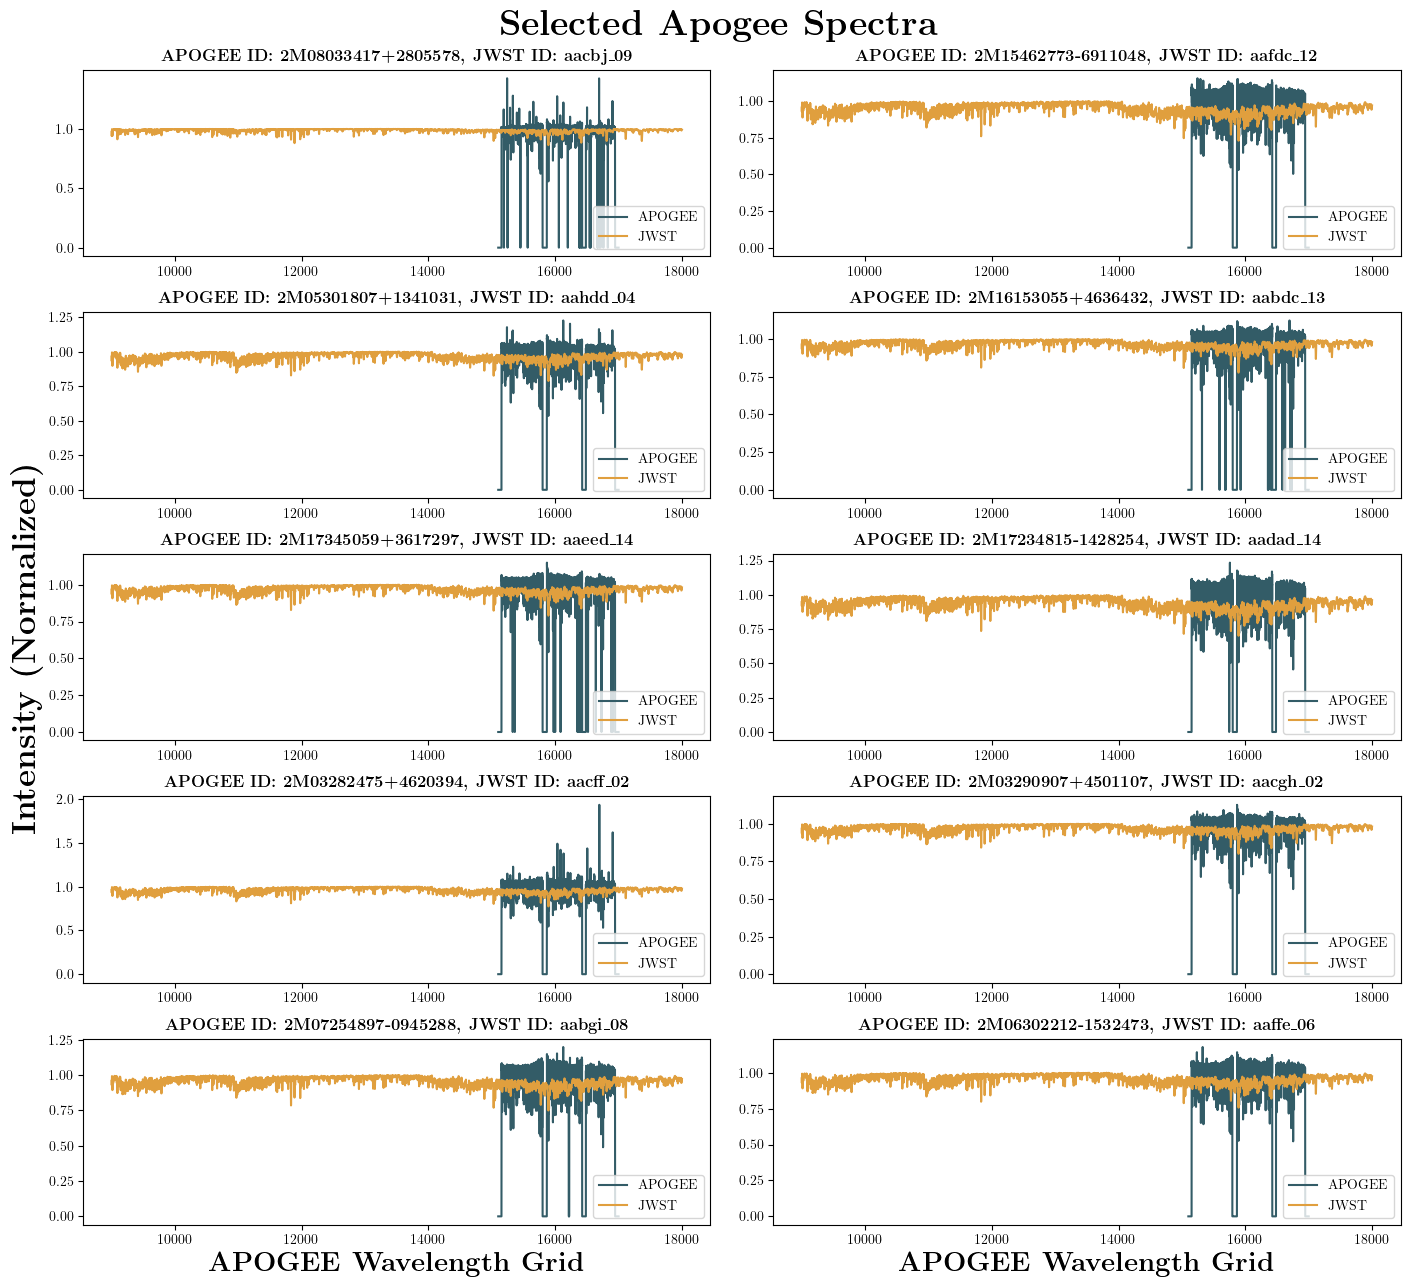

In [ ]:
# Plot a few APOGEE spectra
# Create a figure
fig = plt.figure(figsize=(17, 15))  # Adjust the figure size as needed

# Create a GridSpec object with 5 rows and 2 columns
gs = gridspec.GridSpec(5, 2, figure=fig)
gs.update(wspace=0.1, hspace=0.3)


for i in selected.index:
    JWST_name = selected_JWST_ids[i]
    telescope = selected.loc[i, 'TELESCOPE'].decode("utf-8")
    field = selected.loc[i, 'FIELD'].decode("utf-8")
    file = selected.loc[i, 'FILE'].decode("utf-8")
    file = f"aspcapStar-dr17-{selected.loc[i, 'APOGEE_ID'].decode('utf-8')}.fits"
    path_to_spec = apogee_dr17_dir / telescope / field / file
    hdul = fits.open(path_to_spec)
    apogee_spec = hdul[1].data
    ax = fig.add_subplot(gs[i // 2, i % 2])  # Access the correct grid cell
    ax.plot(apogee_wave, apogee_spec, label = 'APOGEE', c = cs[0]) #plot APOGEE spectra
    ax.plot(jwst_wave, jwst_spectra.loc[JWST_name].values, label = 'JWST', c = cs[2]) #plot JWST spectra


    ax.legend(loc = 'lower right')
    ax.set_title(f'\\textbf{{APOGEE ID: {selected.loc[i, "APOGEE_ID"].decode("utf-8")}, JWST ID: {JWST_name}}}')
    if i // 2 == 4:
        ax.set_xlabel(r'\textbf{APOGEE Wavelength Grid}', fontsize = 20)
    if (i // 2, i % 2) == (2, 0):
        ax.set_ylabel(r'\textbf{Intensity (Normalized)}', fontsize = 24)

fig.suptitle(r'\textbf{Selected Apogee Spectra}', y = 0.92, fontsize = 26)
plt.savefig('figures/selected_spectra_with_JWST.pdf')
plt.show()



For one of the selected stars, repeat the above plot but zoom in on the APOGEE wavelength range. Briefly describe the similarities and differences between the real APOGEE and synthetic JWST spectra. Does it seem reasonable that the two spectra correspond to the same star?


In [ ]:
idx = 4
star = selected.iloc[idx]
JWST_name = selected_JWST_ids[idx]
telescope = star['TELESCOPE'].decode("utf-8")
field = star['FIELD'].decode("utf-8")
file = star['FILE'].decode("utf-8")
file = f"aspcapStar-dr17-{star['APOGEE_ID'].decode('utf-8')}.fits"
path_to_spec = apogee_dr17_dir / telescope / field / file
hdul = fits.open(path_to_spec)
apogee_spec = hdul[1].data

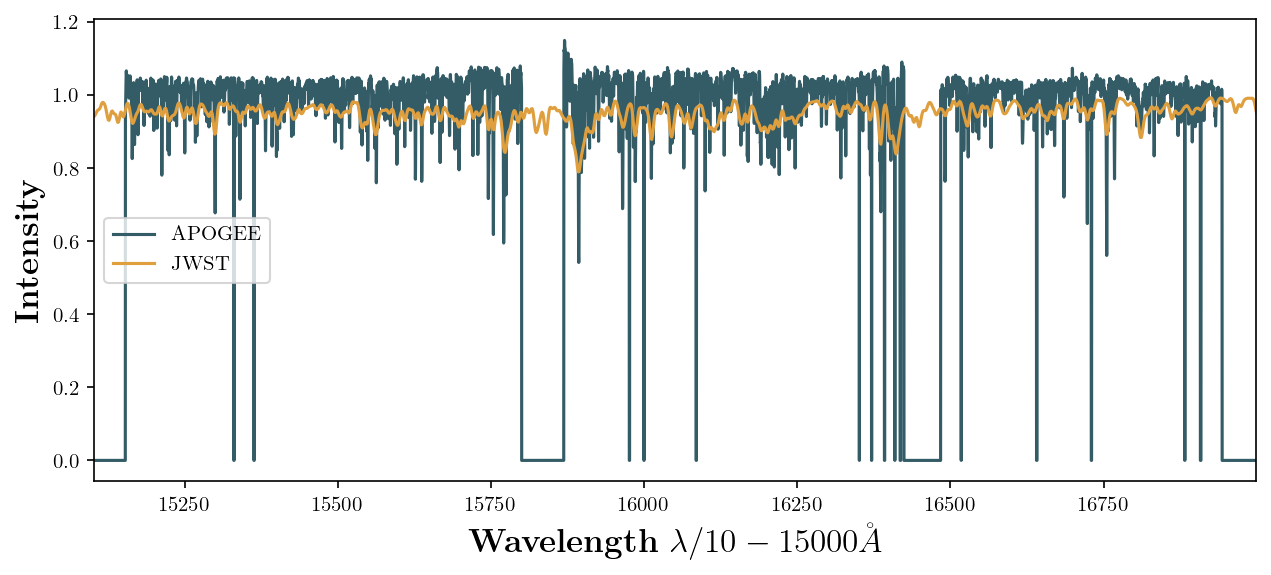

In [ ]:
fig = plt.figure(figsize=(10, 4), dpi = 150)  # Adjust the figure size as needed
ax = fig.add_subplot()  # Access the correct grid cell
ax.plot(apogee_wave, apogee_spec, label = 'APOGEE', c = cs[0]) #plot APOGEE spectra
ax.plot(jwst_wave, jwst_spectra.loc[JWST_name].values, label = 'JWST', c = cs[2]) #plot JWST spectra
ax.set_xlim([min(apogee_wave), max(apogee_wave)])
ax.set_xlabel(r'\textbf{Wavelength} $\lambda / 10 - 15000 \AA$', fontsize = 16)
ax.set_ylabel(r'\textbf{Intensity}', fontsize = 16)

ax.legend()
plt.savefig('figures/selected_spectra_with_JWST_zoomed.pdf')
plt.show()

In [ ]:
print(f'JWST Spectral Coverage: {min(jwst_wave) / 10 + 15000} - {max(jwst_wave) / 10 + 15000}')
print(f'{len(jwst_wave)} pixels in each spectrum')

JWST Spectral Coverage: 15900.0 - 16800.0
8192 pixels in each spectrum


# **2. Neural Network Predictor** <a class = "anchor" id = "neur-net">

## **2.1 Partition the Data** <a class = "anchor" id = "part-data">

In [ ]:
lst_labels = ['TEFF', 'LOGG', 'FE_H'] #select relevant labels

In [ ]:
LOCAL_DATA_DIR = Path('/geir_data/scr/kimjul19/DATA')
apogee_spectra = pd.read_pickle(LOCAL_DATA_DIR / "apogee_spectra.pkl")

In [ ]:
#First, reload everything

apogee_labels = pd.DataFrame(allstars)
## Drop missing data point in APOGEE data with no JWST pair ## 
apogee_labels.drop(index = 11215, inplace = True)

jwst_labels = pd.DataFrame(labels)
jwst_labels['index'] = [name_to_idx(name) for name in jwst_labels.index]
jwst_labels.set_index('index', inplace = True) #standardize index to match APOGEE

#reload the spectra (if needed)
jwst_spectra = pd.read_hdf(jwst_spec_file, 'spectra') #read in spectra
jwst_spectra['index'] = [name_to_idx(name) for name in jwst_spectra.index]
jwst_spectra.set_index('index', inplace = True) #standardize index to match APOGEE

print(f"Shapes of JWST and APOGEE labels before dropping duplicates: {jwst_labels.shape}, {apogee_labels.shape}")

## Drop all duplicates in APOGEE and JWST data ## 
duplicate_indices = apogee_labels[apogee_labels.duplicated(subset='APOGEE_ID', keep='first')].index
apogee_labels.drop(index=duplicate_indices, inplace=True)
jwst_spectra.reset_index(drop=True, inplace=True)
jwst_spectra.drop(index=duplicate_indices, inplace=True) 
jwst_labels.drop(index=duplicate_indices, inplace=True)

apogee_labels.reset_index(drop=True, inplace=True)
jwst_spectra.reset_index(drop=True, inplace=True) 
jwst_labels.reset_index(drop=True, inplace=True)

print(f"Shapes of JWST and APOGEE labels after dropping duplicates: {jwst_labels.shape}, {apogee_labels.shape}")

Shapes of JWST and APOGEE labels before dropping duplicates: (19799, 20), (19799, 55)
Shapes of JWST and APOGEE labels after dropping duplicates: (19001, 20), (19001, 55)


In [ ]:
#re-normalize all the data in both jwst and apogee datasets
scaler = MinMaxScaler()
jwst_labels = pd.DataFrame(
    scaler.fit_transform(labels[lst_labels]),
    columns=lst_labels,
    index=labels.index
)
apogee_labels = pd.DataFrame(scaler.fit_transform(allstars[lst_labels]), columns=lst_labels, index=allstars.index)
apogee_labels['APOGEE_ID'] = allstars['APOGEE_ID'] #add APOGEE ID to the labels
apogee_labels['TELESCOPE'] = allstars['TELESCOPE'] #add telescope to the labels
apogee_labels['FIELD'] = allstars['FIELD'] #add field to the labels
apogee_labels.drop(index=non_match, inplace=True) #drop the non-matching star

#now drop the duplicate indices
duplicate_indices = allstars[allstars.duplicated(subset='APOGEE_ID', keep='first')].index
apogee_labels.drop(index=duplicate_indices, inplace=True) #drop the duplicate indices

duplicate_names = [idx_to_name(idx) for idx in duplicate_indices]
jwst_labels.drop(index=duplicate_names, inplace=True) #drop the duplicate indices

In [ ]:
## Set up seed for reproducibility ## - TAKEN FROM StarNet.ipynb
def set_seed(seed):
    """
    Sets the random seed across multiple libraries to ensure reproducibility in experiments.

    This function fixes randomness in PyTorch, CUDA and NumPy, ensuring
    that results are consistent across multiple runs of the same code.

    Parameters:
    -----------
    seed : int
        The seed value to be used for random number generators.
    """
    torch.cuda.manual_seed(seed) # sets the seed for PyTorch's CUDA operations
    torch.backends.cudnn.deterministic = True # configures cuDNN to enforce deterministic computations
    torch.backends.cudnn.benchmark = False # disables cuDNN benchmarking to prevent non-deterministic behaviour
    np.random.seed(seed) # sets seed for NumPy’s random number generator.

set_seed(42)

In [ ]:
def split_data(X, y, train_test_valid = [5/8, 1/8, 2/8]):
    """ 
    Splits the data into training, testing, and validation sets.
    The function takes in the features and labels, and splits them into three sets based on the provided ratios.
    The function also ensures that the split is stratified based on the labels.
    The function returns the training, testing, and validation sets for both features and labels.
    
    PARAMETERS
    ----------
    X : pd.DataFrame
        The features to be split.
    y : pd.DataFrame
        The labels to be split.
        train_test_valid : list
    train_test_valid = The ratios for splitting the data into training, testing, and validation sets.
        Default is [5/8, 1/8, 2/8].

    RETURNS
    -------
    X_train : pd.DataFrame
        The training features.
    X_test : pd.DataFrame
        The testing features.
    X_valid : pd.DataFrame
        The validation features.
    y_train : pd.DataFrame
        The training labels.
    y_test : pd.DataFrame
        The testing labels.
    y_valid : pd.DataFrame
        The validation labels.
    """
    # create reproducible random numbers to determine training and test sets
    values = ['train', 'validation', 'test'] 
    probabilities = [5/8, 1/8, 2/8] #normalized to 1
    sequence = np.random.choice(values, size=len(apogee_labels), p=probabilities)
    return X[sequence == 'train'].values, X[sequence == 'validation'].values, X[sequence == 'test'].values, y[sequence == 'train'].values, y[sequence == 'validation'].values, y[sequence == 'test'].values, sequence


In [ ]:
X_j_train, X_j_val, X_j_test, y_j_train, y_j_val, y_j_test, sequence = split_data(jwst_spectra, jwst_labels[lst_labels])

## **2.2 Creating the Network** <a class = "anchor" id = "create-network">

In [ ]:
## Define helper function ## 
def compute_out_size(in_size, mod):
    """
    Compute the output size of a PyTorch module `mod` given an input with size `in_size`.

    Args:
        in_size (tuple): The size of the input tensor (excluding batch size).
        mod (torch.nn.Module): The PyTorch module for which to compute the output size.

    Returns:
        tuple: The size of the output tensor (excluding batch size).
    """
    
    f = mod.forward(autograd.Variable(torch.Tensor(1, *in_size)))
    return f.size()[1:]

In [ ]:
## Instantiate neural network parameters ## 
num_filters = [4, 16] # Number of filters used in convolutional layers
filter_length = 8 # Length of the filters in convolutional layers
pool_length = 4 # Length of maxpooling window 
num_hidden = [256, 128] # Number of nodes in each of hidden fully connected layers

In [ ]:
num_jwst_labels = y_j_train.shape[1] # Number of JWST labels  
num_jwst_fluxes = X_j_train.shape[1] # Number of JWST fluxes


In [ ]:
## Define CNN ## 
class StarNet(nn.Module):
    def __init__(self, num_fluxes: int, num_filters: list, filter_length: int, pool_length: int, num_hidden: list, num_labels: int):
        super(StarNet, self).__init__()
        # Define convolutional layers 
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = num_filters[0], kernel_size = filter_length)
        self.conv2 = nn.Conv1d(in_channels = num_filters[0], out_channels = num_filters[1], kernel_size = filter_length)

        # Define pooling layer 
        self.pool = nn.AvgPool1d(pool_length, pool_length)

        # Compute shape after pooling
        pool_output_shape = compute_out_size((1,num_fluxes), nn.Sequential(self.conv1, self.conv2, self.pool))
        
        # Define fully connected layers
        self.fc1 = nn.Linear(in_features = pool_output_shape[0]*pool_output_shape[1], out_features = num_hidden[0])
        self.fc2 = nn.Linear(in_features = num_hidden[0], out_features = num_hidden[1])
        self.output = nn.Linear(in_features = num_hidden[1], out_features = num_labels)
    
    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = torch.flatten(x, start_dim = 1)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.output(x)
        return x

In [ ]:
# Create the model
JWSTModel = StarNet(num_jwst_fluxes, num_filters, filter_length, pool_length, num_hidden, num_jwst_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")
JWSTModel.to(device) 

Device is cuda


StarNet(
  (conv1): Conv1d(1, 4, kernel_size=(8,), stride=(1,))
  (conv2): Conv1d(4, 16, kernel_size=(8,), stride=(1,))
  (pool): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (fc1): Linear(in_features=32704, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=3, bias=True)
)

In [ ]:
summary(JWSTModel, (1, num_jwst_fluxes)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 4, 8185]              36
            Conv1d-2             [-1, 16, 8178]             528
         AvgPool1d-3             [-1, 16, 2044]               0
            Linear-4                  [-1, 256]       8,372,480
            Linear-5                  [-1, 128]          32,896
            Linear-6                    [-1, 3]             387
Total params: 8,406,327
Trainable params: 8,406,327
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.50
Params size (MB): 32.07
Estimated Total Size (MB): 33.60
----------------------------------------------------------------


## **2.3 Train the Model** <a class = "anchor" id = "train-model">

In [ ]:
## Set training parameters ##
set_seed(42)
batch_size = 64
batch_size_val = 128
batch_size_test = 128
num_epochs = 15
learning_rate = 0.001

## Construct optimizers ##
JWSTOptimizer = torch.optim.Adam(JWSTModel.parameters(), lr=learning_rate, weight_decay=0)

## Implement learning rate schedulers ## 
JWSTScheduler = lr_scheduler.StepLR(JWSTOptimizer, step_size=5, gamma=0.1)


In [ ]:
## Define function to create dataloaders ##  -> From StarNet.ipynb
def create_dataloader(X, y, batch_size, shuffle=True):
    """
    Creates a PyTorch DataLoader from input features and labels.
    
    Args:
    - X (array-like): The input features. 
    - y (array-like): The corresponding labels or target values. 
    - batch_size (int): The number of samples per batch to load.
    - shuffle (bool, optional): Whether to shuffle the data at every epoch. Default is True.

    Returns:
    - DataLoader: A DataLoader object that can be used to iterate over the dataset in batches.
    """ 
    set_seed(42) 
    tensor_data = TensorDataset(torch.Tensor(X), torch.Tensor(y))
    return DataLoader(tensor_data, batch_size=batch_size, shuffle=shuffle)

## Convert train, val, test datasets to dataloaders ## 
# JWST 
train_j_dataloader = create_dataloader(X_j_train, y_j_train, batch_size)
val_j_dataloader = create_dataloader(X_j_val, y_j_val, batch_size_val, shuffle=False)
test_j_dataloader = create_dataloader(X_j_test, y_j_test, batch_size_test, shuffle=False)

In [ ]:
## Define funtion to train model ## -> From StarNet.ipynb
def train_model(train_dataloader, val_dataloader, model, optimizer, scheduler, num_epochs=15, epsilon_tol=1e-3, N_stop=5, print_iters=200):
    """
    Trains a PyTorch model with optional early stopping based on validation loss improvement.

    Parameters:
    - train_dataloader (DataLoader): Training data loader.
    - val_dataloader (DataLoader): Validation data loader.
    - model (torch.nn.Module): Model to be trained.
    - optimizer (torch.optim.Optimizer): Optimizer for model updates.
    - scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.
    - num_epochs (int): Maximum number of epochs to train.
    - epsilon_tol (float): Minimum required improvement in validation loss to reset early stopping counter.
    - N_stop (int or None): Number of consecutive epochs without sufficient improvement before stopping. If None, early stopping is disabled.
    - print_iters (int): Number of iterations before printing training loss update.

    Returns:
    - train_losses (list): Training loss per epoch.
    - val_losses (list): Validation loss per epoch.
    """
    set_seed(42) 
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    no_improve_epochs = 0  # Counter for early stopping

    print("Begin training \n") 

    for epoch in range(num_epochs):
        running_train_loss = 0.0
        model.train()

        # Training Loop
        for i, (X_batch, y_batch) in enumerate(train_dataloader):
            optimizer.zero_grad()
            y_pred = model(X_batch.unsqueeze(1).to(device))
            loss = nn.MSELoss()(y_pred.to(device), y_batch.to(device))

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

            # Print statistics every 'print_iters' iterations
            if (i + 1) % print_iters == 0 or (i + 1) == len(train_dataloader):
                print(f'[Epoch {epoch + 1}, {(i + 1) / len(train_dataloader) * 100:.0f}%] '
                      f'Train Loss: {running_train_loss / (i + 1):.4f}', end="\r")
        
        train_loss = running_train_loss / len(train_dataloader)

        # Validation Loop
        running_val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_dataloader:
                y_pred = model(X_batch.unsqueeze(1).to(device))
                loss = nn.MSELoss()(y_pred.to(device), y_batch.to(device))
                running_val_loss += loss.item()
        
        val_loss = running_val_loss / len(val_dataloader)
        
        print(f'[Epoch {epoch + 1}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'LR: {scheduler.get_last_lr()[0]:.6f}')
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Early Stopping Logic (if enabled)
        if N_stop is not None:
            if best_val_loss - val_loss >= epsilon_tol:
                best_val_loss = val_loss
                no_improve_epochs = 0  # Reset counter if improvement is significant
            else:
                no_improve_epochs += 1

            if no_improve_epochs >= N_stop:
                print(f"Early stopping triggered after {epoch + 1} epochs. No improvement of at least {epsilon_tol} for {N_stop} consecutive epochs.")
                break  # Stop training

        # Step the scheduler
        scheduler.step()
    
    print("Finished Training \n")
    return train_losses, val_losses

In [ ]:
## Train models with early stopping ##
# JWST
start_time = time.time()
train_j_losses, val_j_losses = train_model(
    train_j_dataloader, val_j_dataloader, JWSTModel,
    JWSTOptimizer, JWSTScheduler
)
print(f"JWST training time: {time.time() - start_time:.2f} seconds\n")


Begin training 

[Epoch 1] Train Loss: 0.1214, Val Loss: 0.0210, LR: 0.001000
[Epoch 2] Train Loss: 0.0204, Val Loss: 0.0193, LR: 0.001000
[Epoch 3] Train Loss: 0.0191, Val Loss: 0.0201, LR: 0.001000
[Epoch 4] Train Loss: 0.0184, Val Loss: 0.0193, LR: 0.001000
[Epoch 5] Train Loss: 0.0176, Val Loss: 0.0180, LR: 0.001000
[Epoch 6] Train Loss: 0.0151, Val Loss: 0.0145, LR: 0.000100
[Epoch 7] Train Loss: 0.0143, Val Loss: 0.0137, LR: 0.000100
[Epoch 8] Train Loss: 0.0135, Val Loss: 0.0131, LR: 0.000100
[Epoch 9] Train Loss: 0.0127, Val Loss: 0.0124, LR: 0.000100
[Epoch 10] Train Loss: 0.0122, Val Loss: 0.0117, LR: 0.000100
[Epoch 11] Train Loss: 0.0116, Val Loss: 0.0117, LR: 0.000010
[Epoch 12] Train Loss: 0.0115, Val Loss: 0.0116, LR: 0.000010
[Epoch 13] Train Loss: 0.0114, Val Loss: 0.0115, LR: 0.000010
[Epoch 14] Train Loss: 0.0114, Val Loss: 0.0114, LR: 0.000010
[Epoch 15] Train Loss: 0.0113, Val Loss: 0.0113, LR: 0.000010
Early stopping triggered after 15 epochs. No improvement of at